# logistic regression

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
from module_DTI import load_data

In [11]:
def get_DTI_dict_from_adjmat(adjmat):
    dict_DTI=dict()
    adjmat=adjmat.T
    i=0
    for drug in adjmat.keys():
        target_list=adjmat.index[adjmat[drug]==1].tolist()
        dict_DTI[drug]=target_list
        i+=len(target_list)
    print('# of drug-target interactions: '+str(i)+'\n')
    return dict_DTI
dir_dataset='D:\\Wisdom\\research\\data\\2012, Tabei'

dir_DTI_adjmat=dir_dataset+'\\inter_admat.txt'
dir_drug=dir_dataset+'\\drug_repmat.txt'
dir_target = dir_dataset + '\\target_repmat.txt'

matrix_DTI = load_data.load_drug_target_interaction_adjacency_matrix(dir_DTI_adjmat)
matrix_drug=load_data.load_drug_descriptor_matrix(dir_drug)
matrix_target=load_data.load_target_descriptor_matrix(dir_target)
dict_DTI = get_DTI_dict_from_adjmat(matrix_DTI)

dir_pos='./sample/pos_sample.txt'
dir_neg = './sample/neg_sample.txt'

pos_samples = load_data.load_pos_samples(dir_pos)
neg_samples = load_data.load_neg_samples(dir_neg)


# of drug: 1862
# of target: 1554

# of drugs: 1862
# of features of a drug: 881

# of targets: 1554
# of features of a target: 876

# of drug-target interactions: 4809

# of positive samples: 4809
# of features of a positive sample: 1757

# of negative samples: 4809
# of features of a negative sample: 1757



In [100]:
def reduce_sample_size(sample):
    pass

In [153]:
def split_train_test_set(pos_samples,neg_samples,split_ratio=0.9):
    pos_label=pos_samples.index
    neg_label=neg_samples.index
    n_pos=pos_samples.shape[0]
    n_neg=neg_samples.shape[0]
    if pos_samples.shape[1] != neg_samples.shape[1]:
        raise ValueError('# of features of a positive sample is not equal to # of features of a positive sample')
    pos_rand=pos_samples.sample(frac=1)
    pos_training=pos_rand.loc[pos_rand.index[:int(split_ratio*n_pos)]]
    pos_test=pos_rand.loc[pos_rand.index[int(split_ratio*n_pos):]]
    neg_rand=neg_samples.sample(frac=1)
    neg_training=neg_rand.loc[neg_rand.index[:int(split_ratio*n_neg)]]
    neg_test=neg_rand.loc[neg_rand.index[int(split_ratio*n_neg):]]
    
    training_samples=pos_training.T.join(neg_training.T)
    training_samples=training_samples.T
    training_samples=training_samples.sample(frac=1)
    test_samples=pos_test.T.join(neg_test.T)
    test_samples=test_samples.T
    test_samples=test_samples.sample(frac=1)
    return training_samples, test_samples


In [154]:
# total_samples=pos_samples.T.join(neg_samples.T)
# total_samples=total_samples.T
# print(total_samples.shape)
# print(total_samples)
training_samples,test_samples=split_train_test_set(pos_samples,neg_samples,split_ratio=0.6)

(5770, 1757)
(3848, 1757)


In [290]:
def next_batch(num,data):
    idx = np.arange(0 , data.shape[0])
    np.random.shuffle(idx)
    idx = idx[:num]
    
    idx_pair=data.index[idx]
    label=list()
    for pair in idx_pair:
        if pair in pos_label:
            label.append([0,1])
        elif pair in neg_label:
            label.append([1,0])
        else:
            raise ValueError('Index pair ('+pair+') belongs to neither pos/neg label.')
    return data.loc[idx_pair].values, np.array(label)

In [296]:
lr=0.05
feature_size=1757
n_class=2
batch_size=100
training_epochs=10

In [297]:
x=tf.placeholder(tf.float32,[None,feature_size])
W=tf.Variable(tf.zeros([feature_size,n_class]),name='W')
b=tf.Variable(tf.zeros([n_class]),name='b')
y=tf.nn.softmax(tf.matmul(x,W)+b)
y_=tf.placeholder(tf.float32,[None,n_class])

In [298]:
print(tf.trainable_variables())

[<tf.Variable 'W:0' shape=(1757, 2) dtype=float32_ref>, <tf.Variable 'b:0' shape=(2,) dtype=float32_ref>]


In [299]:
cost=tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y),reduction_indices=[1]))
optimizer=tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
# accuracy_train=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1),tf.argmax(y_,1)),tf.float32))

print(cost)
print(optimizer)
sess=tf.Session()


Tensor("Mean:0", shape=(), dtype=float32)
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_W/ApplyGradientDescent"
input: "^GradientDescent/update_b/ApplyGradientDescent"



In [302]:
batch_xs,batch_ys=next_batch(batch_size,training_samples)
print(batch_xs.shape)
print(batch_ys.shape)
print(batch_xs[0,:])
print(batch_ys[0,:])

(10, 1757)
(10, 2)
[1 1 1 ... 0 0 0]
[1 0]


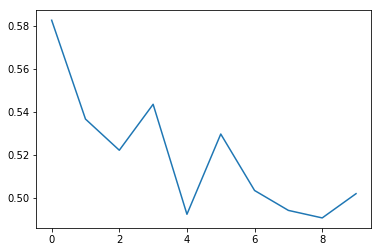

In [303]:
init=tf.global_variables_initializer()
sess.run(init)
avg_cost_list=[]
total_batch=int(training_samples.shape[0]/batch_size)
for epoch in range(training_epochs):
    # accuracy_list=[]
    avg_cost=0.
    
    for step in range(total_batch):
        batch_xs,batch_ys=next_batch(batch_size,training_samples)
        sess.run(optimizer,feed_dict={x:batch_xs,y_:batch_ys})
        avg_cost+=sess.run(cost,feed_dict={x:batch_xs,y_:batch_ys})/total_batch
    avg_cost_list.append(avg_cost)
plt.plot(range(training_epochs),avg_cost_list)
# show training accuracy as iteraction in one epoch
#         accuracy_list.append(sess.run(accuracy_train,feed_dict={x:batch_xs,y_:batch_ys}))
# itr=range(total_batch)
# acc=accuracy_list
# plt.plot(itr,acc)
# plt.xlabel('iteraction')
# plt.ylabel('training accuracy')
# plt.show()

In [306]:
correct_prediction=tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,dtype='float32'))
test_x, test_y=next_batch(test_samples.shape[0],test_samples)
print(test_samples.shape[0])
ac=sess.run(accuracy,feed_dict={x:test_x, y_:test_y})
print(str(ac*100)+'%')


3848
60.00000238418579%


In [307]:
sess.close()

In [ ]:

# d1 = {'col1': np.array(range(1,3)), 'col2': np.array(range(3,5))}
# d2 = {'aa1': np.array(range(1,4)), 'aa2': np.array(range(4,7)),'aa3':np.array(range(7,10))}
# a = pd.DataFrame(data=d1, index=['a','b'])
# print(a)
# b = pd.DataFrame(data=d2,index=['x','y','z'])
# print(b)
# n_feature_drug=len(a.keys())
# n_feature_target=len(b.keys())
# n_sample_drug=len(a.index)
# n_sample_target=len(b.index)
# index=list(a.index)*5
# c=pd.DataFrame(pd.np.tile(a, (n_sample_target, 1)),columns=a.keys())
# ind_pair=[]
# for ind1 in b.index:
#     for ind2 in a.index:
#         ind_pair.append(str(ind2)+'_'+str(ind1))

# d=pd.DataFrame(np.reshape(pd.np.tile(b,(1,n_sample_drug)),(n_sample_drug*n_sample_target,n_sample_target)),
#                columns=b.keys())
# print(d)

# kp=pd.concat([c,d], axis=1)
# kp.index=ind_pair
# print(kp)
# # matrix_DTpair=my_tensordot(matrix_drug,matrix_target)
# kp.to_csv('test.txt',sep='\t')

# a,b=next_batch(10,training_samples)
# print(type(a))
# print(a)
# print(b)
# print(a.shape)
# print(b.shape)
#     data_shuffle = [data[ i] for i in idx]
#     labels_shuffle = [labels[ i] for i in idx]

#     return np.asarray(data_shuffle), np.asarray(labels_shuffle)
# batch_xs,batch_ys=mnist.train.next_batch(100)
# print(batch_xs.shape)
# print(batch_ys.shape)
# # print(batch_xs[0,:])
# # print(batch_ys[0,:])